# Integration with Scipy's `solve_ivp` function

The extensisq package uses the `solve_ivp` function from `scipy.integrate`. This notebook demonstrates some options of this function that you may find useful. The other example notebooks may assume these as background knowledge. This notebook may be less interesting for you if you already know `solve_ivp` well.

## Default integration

Let's call `solve_ivp` with the minimal number of arguments to solve the linear mass spring equation.

In [6]:
from scipy.integrate import solve_ivp

def ode_mass_sping(t, y, m=1.0, k=1.0):
    x, v = y
    a = -k/m*x
    dydt = [v, a]
    return dydt

t_span = [0.0, 10.0]
y0 = [1.0, 0.0]
sol = solve_ivp(ode_mass_sping, t_span, y0)

print('Success:', sol.success)
print('Nr of function evaluations:', sol.nfev)

Success: True
Nr of function evaluations: 86


We have just integrated the mass spring ODE over a time interval `t_span` for initial conditions `y0` (displacement = 1, velocity = 0).

Now we can plot the solution.

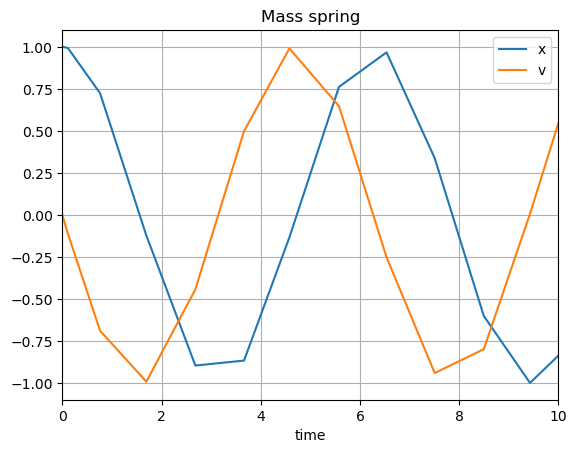

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_result(t, y):
    plt.figure()
    plt.plot(t, y)
    plt.title("Mass spring")
    plt.xlabel('time')
    plt.xlim(t_span)
    plt.grid()

plot_result(sol.t, sol.y.T)
plt.legend(['x','v'])
plt.show()

The solution is a cosine and a sine, as expected, but the resolution is poor because of the large steps taken by the solver. This is beneficial for efficiency, but not for aesthetics. 

Naive workarounds to get more output points are, from worst to still bad:
* Limit the solver to a very small time step (using the `max_step` argument)
* Reduce the tolerance to very low values (using the `rtol` and `atol` arguments)
* use a method of lower order (for example: 'RK23', or `extensisq.HE2`)
* use a multistep method (for example: 'LSODA' or `extensisq.SWAG`)

None of these options are elegant. We already have a good, sufficiently accurate solution. Why not interpolate it? 

This is exactly what the arguments `t_eval` and `dense_output` do.

## Output at pre-defined points using `t_eval`

If we know beforehand at which points in time we want to have the solution, we can use `t_eval`. Let's see what it does.


Success: True
Nr of function evaluations: 86


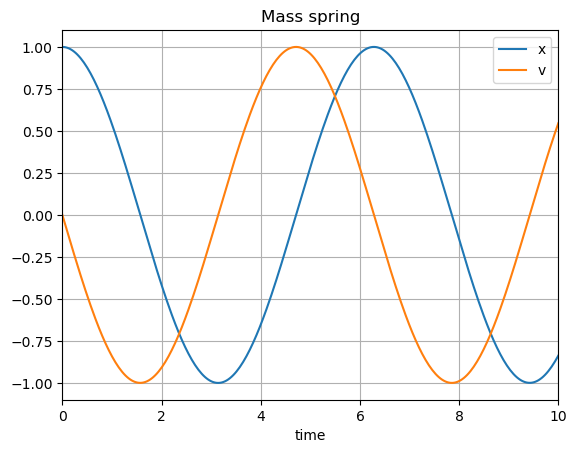

In [8]:
import numpy as np

t_eval = np.linspace(*t_span, 300)
sol = solve_ivp(ode_mass_sping, t_span, y0, t_eval=t_eval)
print('Success:', sol.success)
print('Nr of function evaluations:', sol.nfev)

plot_result(sol.t, sol.y.T)
plt.legend(['x', 'v'])
plt.show()

The number of function evaluations remains the same as before. The plot however, is much nicer. 

Notice that the meaning of `sol.t` and `sol.y` have changed. These are not the solver solution points anymore. `sol.t` is just `t_eval` and `sol.y` is interpolated solution at these points in time.

## Calculating a smooth function of the solution using `dense_output`

In some use cases, we don't know the required resolution beforehand. For example, if want to find the minimum or root of the solution. In such cases, we can use `dense_output` to create a function of the interpolated solution (at an increased memory footprint). 

Lets find the point in time between 2 and 4 where the velocity is 0, as an example.

Success: True
Nr of function evaluations: 86

root converged: True
root: 3.140960745892153


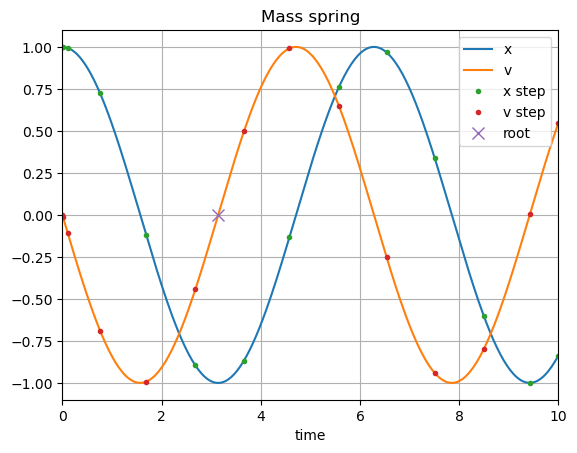

In [9]:
from scipy.optimize import root_scalar

sol = solve_ivp(ode_mass_sping, t_span, y0, dense_output=True)
print('Success:', sol.success)
print('Nr of function evaluations:', sol.nfev)

def f_sol(t, sol=sol): return sol.sol(t)[1]      # return only the velocity
bracket = [2.0, 4.0]
root = root_scalar(f_sol, bracket=bracket)
print('\nroot converged:', root.converged)
print('root:', root.root)

plot_result(t_eval, sol.sol(t_eval).T)
plt.plot(sol.t, sol.y.T, '.')
plt.plot(root.root, 0.0, 'x', ms=9, label='root')
plt.legend(['x','v', 'x step', 'v step', 'root'])
plt.show()

Again, the same number of function evaluations are needed for the integration. The contents of `sol.t` and `sol.y` are the solver points again. The interpolant of the solution is now available as `sol.sol`. This allows to plot the graph at `t_eval`. 

`sol.sol` is also used to find the root. The function `f_sol` was only defined to return the velocity instead of the array with displacement and velocity. The root is close to the exact value $\pi$. The tolerances of the integration could be lowered to get closer to $\pi$. (For example, add `rtol=1e-9` and `atol=1e-9` to the `solve_ivp` call.)

## Conditional termination of the integration using `events`

Another use of interpolation is with events. Events can be used to stop the integration under a given condition. Lets model a bouncing ball with this as example.

success: True
message: A termination event occurred.
Nr of function evaluations: 38 

success: True
message: A termination event occurred.
Nr of function evaluations: 19 

success: True
message: The solver successfully reached the end of the integration interval.
Nr of function evaluations: 13 



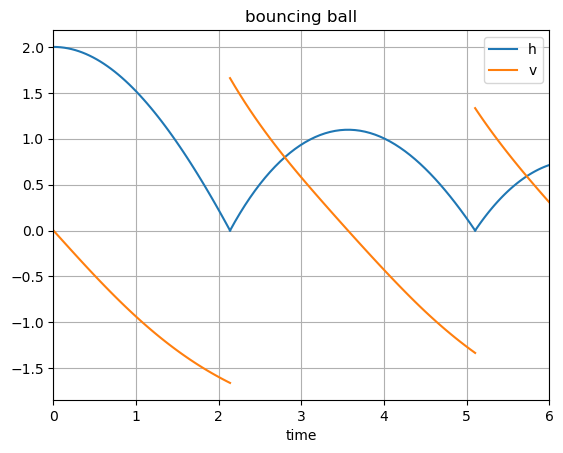

In [10]:
def ball(t, y, gravity=-1.0, drag=0.2):
    h, v = y
    a = gravity - drag * abs(v) * v
    dydt = [v, a]
    return dydt

def bounce(t, y):
    h, v = y
    return h

bounce.terminal = True
bounce.direction = -1.0

y0 = [2.0, 0.0]
t = 0.0
t_end = 6.0
first_step = None
solutions = []
while t < t_end:
    t_span = [t, t_end]
    sol = solve_ivp(ball, t_span, y0, events=bounce, 
                    dense_output=True, first_step=first_step)
    print('success:', sol.success)
    print('message:', sol.message)
    print('Nr of function evaluations:', sol.nfev, '\n')
    solutions.append(sol)
    
    t = sol.t[-1]
    y0 = [0, -sol.y[1, -1]]     # reverse velocity, no loss
    first_step = min(t - sol.t[-2],  t_end - t)

plt.figure()
for sol in solutions:
    t_plot = np.linspace(sol.t[0], sol.t[-1])
    result = sol.sol(t_plot)
    plt.plot(t_plot, result[0, :], 'C0')
    plt.plot(t_plot, result[1, :], 'C1')
plt.grid()
plt.legend(('h', 'v'))
plt.xlim([0, t_end])
plt.xlabel('time')
plt.title('bouncing ball')
plt.show()

The function `ball` calculates the acceleration of a point mass under gravity and drag loads (with arbitrary normalization). The `bounce` function just returns the height. It is used as the event function that stops the integration if the height of the ball turns negative. The exact behavior is set by the attributes `terminal` and `direction`.

The while loop is used to restart the integration after each event. The velocity is reversed each time, that is an elastic bounce. The two other arguments are `first_step` and `dense_output`. Each integration typically starts with a rather small time step and uses a few steps to get on scale; see the plot of the mass spring for example. If an event terminates the integration, we can calculate the size of the last step from `sol.t` (if `t_eval` is not used). Scince this step is probably on scale, we can use it to restart the integration. This saves a few function evaluations. (Don't do this for multistep methods that start at a lower order.)

The plot shows the expected behavior. The height of the bounce reduces over time due to drag. (Set it to 0 to test.)

## About Jacobians

Jacobians are typically used in implicit methods. These are useful to solve stiff problems. The performance of these implicit methods are often improved if the Jacobian is provided with argument `jac`. The derivation of the Jacobian can be cumbersome in many real problems though. Extensisq only provides explicit methods. Most methods include stiffness detection, which tries to estimate some properties of the Jacobian. None of these methods use the `jac` argument though. Therefore, it is not further discussed here.